# Retrieving SMAP data

## SMAP Description

Data Product:
* Level 4 - daily gridded, 9km enhanced. Available with 2-3 day latency

Documentation: 

https://nsidc.org/sites/default/files/documents/user-guide/multi_spl4smau-v007-userguide.pdf

https://developers.google.com/earth-engine/datasets/catalog/NASA_SMAP_SPL4SMGP_008

## Joining with HRRR

The HRRR weather model is the main driver of the FMC forecasts. HRRR is higher resolution both spatially and temporally. We wish to extract the SMAP soil moisture data at locations that correspond to the HRRR grid nodes.

Spatial Info:
- HRRR: 3km grid, grid nodes, Lambert Conformal
- SMAP L4: 9km grid, grid cell center, Lambert Cylindrical

Method: nearest neighbors, find SMAP grid cell that HRRR grid node falls within. Consider SMAP data constant in that region, allow models to correct with internal spatial interpolation

Steps:
- Get a HRRR file with `Herbie`, arbitrary date. We just want the spatial info
- Use the terrain fields in HRRR, orographic height and land-sea-mask. This is somewhat arbitrary, but we are picking variables that we don't expect to change over time to make this process stable
- 

## Setup

In [1]:
import earthaccess
import herbie
from pyproj import CRS, Transformer
import pandas
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
earthaccess.login()

## Retrieve

In [3]:
collection = "SPL4SMGP"   
version = "008"
time_range = ("2023-01-01", "2023-01-02")

granules = earthaccess.search_data(
    short_name=collection,
    version=version,
    temporal=time_range
)

print(f"Found {len(granules)} granules")

Found 17 granules


## Read and Explore

In [4]:
files = earthaccess.open(granules)

QUEUEING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/17 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/17 [00:00<?, ?it/s]

In [5]:
fname = files[1]
print(f"Reading file: {fname}")
time_info = {}


# Get Meta
with h5py.File(fname, "r") as f:
    print(list(f.keys())) 
    meta = f["Metadata"]
    print("Metadata keys:", list(meta.keys()))

Reading file: <File-like object HTTPFileSystem, https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/SMAP/SPL4SMGP/008/2023/01/01/SMAP_L4_SM_gph_20230101T013000_Vv8010_001.h5>
['EASE2_global_projection', 'Geophysical_Data', 'Metadata', 'cell_column', 'cell_lat', 'cell_lon', 'cell_row', 'time', 'x', 'y']
Metadata keys: ['AcquisitionInformation', 'CRID', 'Config', 'DataQuality', 'DatasetIdentification', 'Extent', 'GridSpatialRepresentation', 'ProcessStep', 'SeriesIdentification', 'Source']


In [6]:

proj_info = {}

with h5py.File(fname, "r") as f:
    
    
    dset = f["EASE2_global_projection"]
    for key, val in dset.attrs.items():
        # Convert bytes → string if needed
        if isinstance(val, bytes):
            val = val.decode()
        proj_info[key] = val

print(proj_info)

{'false_easting': 0.0, 'false_northing': 0.0, 'grid_mapping_name': 'lambert_cylindrical_equal_area', 'longitude_of_central_meridian': 0.0, 'standard_parallel': 30.0}


In [7]:
with h5py.File(fname, "r") as f:
    geo = f["Geophysical_Data"]
    fields = list(geo.keys())

sm_vars = [k for k in fields if k.startswith("sm_")]
print(sm_vars)

['sm_profile', 'sm_profile_pctl', 'sm_profile_wetness', 'sm_rootzone', 'sm_rootzone_pctl', 'sm_rootzone_wetness', 'sm_surface', 'sm_surface_wetness']


In [8]:
with h5py.File(fname, "r") as f:
    x_smap = f["x"][:]          # 1D array
    y_smap = f["y"][:]          # 1D array

    # pick one field for testing
    data = f["Geophysical_Data"]["sm_surface"][:]  

print("x shape:", x_smap.shape)
print("y shape:", y_smap.shape)
print("data shape:", data.shape)
print("data dtype:", data.dtype)

x shape: (3856,)
y shape: (1624,)
data shape: (1624, 3856)
data dtype: float32


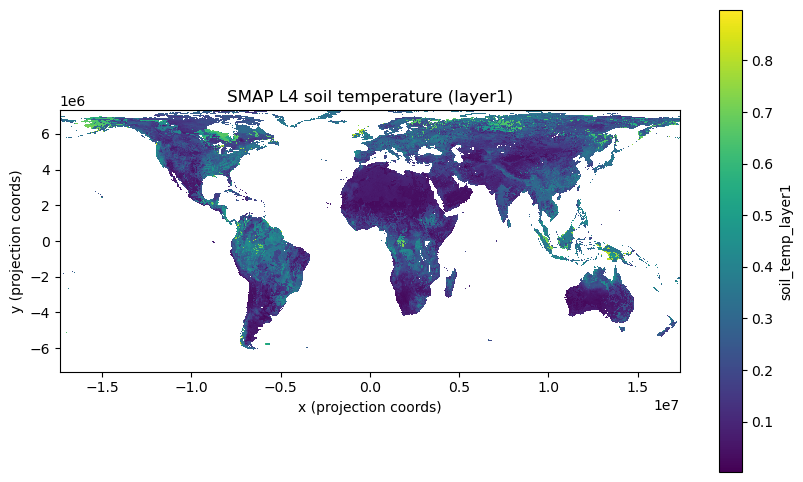

In [20]:
masked_data = np.where(data == -9999.0, np.nan, data)

xmin, xmax = x_smap.min(), x_smap.max()
ymin, ymax = y_smap.min(), y_smap.max()b

plt.figure(figsize=(10,6))
plt.imshow(
    np.flipud(masked_data),
    extent=(xmin, xmax, ymin, ymax),
    origin="lower",
    interpolation="nearest"
)

plt.colorbar(label="soil_temp_layer1")
plt.title("SMAP L4 soil temperature (layer1)")
plt.xlabel("x (projection coords)")
plt.ylabel("y (projection coords)")
plt.show()

## Join with HRRR

### Get a HRRR data file to use spatial info

In [13]:
# Retrieve a HRRR forcast
hrrr = herbie.Herbie(date="2025-01-01 00:00:00", model="hrrr", product="prs")

✅ Found ┊ model=hrrr ┊ product=prs ┊ 2025-Jan-01 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws


In [14]:
# Get terrain fields
ds = hrrr.xarray("(?:HGT|LAND):surface")

/opt/anaconda3/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:129: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dtype attribute, which is now xarray's default way of encoding timedelta64 values. To continue decoding timedeltas based on the presence of a timedelta-like units attribute, users will need to explicitly opt-in by passing True or CFTimedeltaCoder(decode_via_units=True) to decode_timedelta. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  vars, attrs, coord_names = xr.conventions.decode_cf_variables(
/opt/anaconda3/lib/python3.12/site-packages/cfgrib/xarray_plugin.py:129: FutureWarning: In a future version, xarray will not decode timedelta values based on the presence of a timedelta-like units attribute by default. Instead it will rely on the presence of a timedelta64 dt

### Join

- Using SMAP projection info, Lambert Cylindrical, we convert the HRRR lon/lat grid nodes to planar coordinates in the Lamb-Cylindrical system.
- Using SMAP cell-center x and y coords, assign each HRRR node to one of those cells

In [15]:
# SMAP Lambert Cylindrical
smap_crs = CRS.from_cf({
    "grid_mapping_name": "lambert_cylindrical_equal_area",
    "standard_parallel": 30.0,
    "longitude_of_central_meridian": 0.0,
    "false_easting": 0.0,
    "false_northing": 0.0
})

# # WGS 84 / standard lat/lon
# geo_crs = CRS.from_epsg(4326)

# # Transformer: lon/lat -> SMAP x/y 
# transformer = Transformer.from_crs(
#     geo_crs, smap_crs, always_xy=True
# )

transformer = Transformer.from_crs(4326, smap_crs, always_xy=True)
xs, ys = transformer.transform(ds["longitude"].values, ds["latitude"].values)

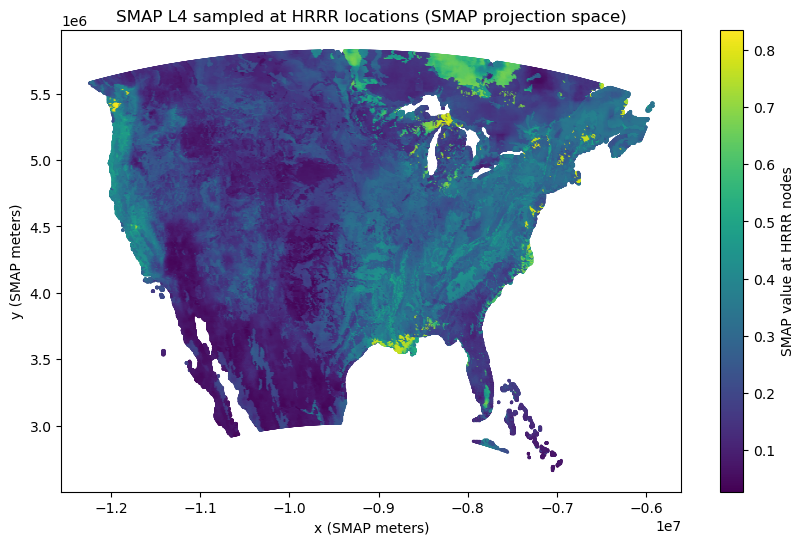

In [23]:
# compute nearest SMAP indices\

# x axis (increasing)
ix = np.searchsorted(x_smap, xs)
ix = np.clip(ix, 1, len(x_smap) - 1)
ix = np.where(
    np.abs(xs - x_smap[ix - 1]) <= np.abs(xs - x_smap[ix]),
    ix - 1,
    ix
)

i = ix

# y axis (decreasing)
y_rev = y_smap[::-1]  # make increasing
jy = np.searchsorted(y_rev, ys)
jy = np.clip(jy, 1, len(y_rev) - 1)
jy = np.where(
    np.abs(ys - y_rev[jy - 1]) <= np.abs(ys - y_rev[jy]),
    jy - 1,
    jy
)
j = (len(y_smap) - 1) - jy  # back to native indexing

# sample SMAP 
vals = masked_data[j, ix]

# plot in SMAP projection space 
plt.figure(figsize=(10, 6))
plt.scatter(xs, ys, c=vals, s=1)
plt.colorbar(label="SMAP value at HRRR nodes")
plt.title("SMAP L4 sampled at HRRR locations (SMAP projection space)")
plt.xlabel("x (SMAP meters)")
plt.ylabel("y (SMAP meters)")
plt.show()


In [24]:
sm_surface = masked_data[j, i]

ds["sm_surface"] = xr.DataArray(
    sm_surface,
    dims=("y", "x"),
    coords={"y": ds["y"], "x": ds["x"]},
    attrs={
        "long_name": "SMAP L4 surface soil moisture",
        "source": "SMAP L4 nearest-cell assignment (no interpolation)",
    },
)

In [43]:
# Check Soil units - Expect between 0 and 1
print("~"*50)
print("Checking surface sm")
print(f"    Min SM Surface: {np.nanmin(masked_data)}")
print(f"    Max SM Surface: {np.nanmax(masked_data)}")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Checking surface sm
    Min SM Surface: 0.0024075601249933243
    Max SM Surface: 0.8976945877075195


## Validating

Series of checks to validate the spatial join:

### Visualize

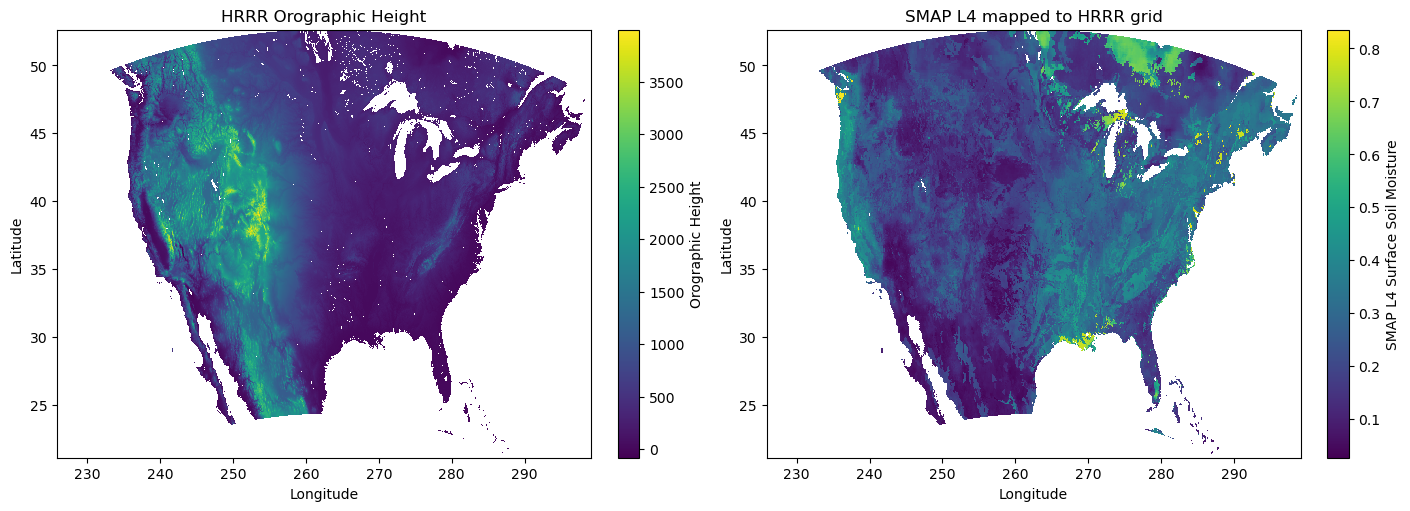

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), constrained_layout=True)

# HRRR Orographic Height, mask out by lsm
ds["orog"] = ds.orog.where(ds.lsm > 0)
pcm0 = axes[0].pcolormesh(
    ds["longitude"],
    ds["latitude"],
    ds["orog"],
    shading="nearest"
)
fig.colorbar(pcm0, ax=axes[0], label="Orographic Height")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
axes[0].set_title("HRRR Orographic Height")

# SMAP mapped to HRRR grid 
pcm1 = axes[1].pcolormesh(
    ds["longitude"],
    ds["latitude"],
    ds["sm_surface"],
    shading="nearest"
)
fig.colorbar(pcm1, ax=axes[1], label="SMAP L4 Surface Soil Moisture")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
axes[1].set_title("SMAP L4 mapped to HRRR grid")

plt.show()

### Confirm SMAP Projection Info

In [31]:
smap_crs

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Cylindrical Equal Area
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [32]:
print("~"*50)
print("SMAP L4 Projection Info from EarthAccess:")
for k, v in proj_info.items():
    print(f"    {k}: {v}")

print()
print("~" * 50)
print("SMAP CRS from Pyproj:")

print("    Projection name:", smap_crs.coordinate_operation.method_name)

params = smap_crs.coordinate_operation.params
for p in params:
    print(f"    {p.name}: {p.value}")

print("~" * 50)
print("Explicit parameter comparison:")

param_map = {
    "Latitude of 1st standard parallel": "standard_parallel",
    "Longitude of natural origin": "longitude_of_central_meridian",
    "False easting": "false_easting",
    "False northing": "false_northing",
}

crs_params = {
    p.name: p.value
    for p in smap_crs.coordinate_operation.params
}

for crs_name, h5_name in param_map.items():
    print(
        f"{crs_name:40s} | "
        f"CRS: {crs_params.get(crs_name)} "
        f"HDF5: {proj_info[h5_name]}"
    )

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SMAP L4 Projection Info from EarthAccess:
    false_easting: 0.0
    false_northing: 0.0
    grid_mapping_name: lambert_cylindrical_equal_area
    longitude_of_central_meridian: 0.0
    standard_parallel: 30.0

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SMAP CRS from Pyproj:
    Projection name: Lambert Cylindrical Equal Area
    Latitude of 1st standard parallel: 30.0
    Longitude of natural origin: 0.0
    False easting: 0.0
    False northing: 0.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Explicit parameter comparison:
Latitude of 1st standard parallel        | CRS: 30.0 HDF5: 30.0
Longitude of natural origin              | CRS: 0.0 HDF5: 0.0
False easting                            | CRS: 0.0 HDF5: 0.0
False northing                           | CRS: 0.0 HDF5: 0.0


### Check HRRR Nodes to SMAP Indices

In [33]:
ny, nx = masked_data.shape

total = i.size

oob = (
    (i < 0) | (i >= nx) |
    (j < 0) | (j >= ny)
)

n_oob = np.count_nonzero(oob)

print("Total HRRR nodes        :", total)
print("Out-of-bounds nodes     :", n_oob)
print("Fraction out-of-bounds  :", n_oob / total)

Total HRRR nodes        : 1905141
Out-of-bounds nodes     : 0
Fraction out-of-bounds  : 0.0


### Axis Orientation

Confirm we didn't flip y-axis, as is common in spatial join products. Usually, y-axis increased N -> S, rather than bottom -> top like classic Euclidean coords. Confirm this is the case in both SMAP and HRRR

In [34]:
print("~"*50)
print("SMAP y-axis orientation")
print("    y_smap[0], y_smap[-1]:", y_smap[0], y_smap[-1])
print("    y_smap decresing:", np.all(np.diff(y_smap) < 0))

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
SMAP y-axis orientation
    y_smap[0], y_smap[-1]: 7310037.171386719 -7310037.171386719
    y_smap decresing: True


In [35]:
lat = ds["latitude"].values

south_idx = np.unravel_index(np.argmin(lat), lat.shape)
north_idx = np.unravel_index(np.argmax(lat), lat.shape)

print("~"*50)
print("HRRR y-axis orientation")
print("    Southernmost HRRR latitude :", lat[south_idx])
print("    Northernmost HRRR latitude :", lat[north_idx])
print("    SMAP j at southern HRRR pt :", j[south_idx])
print("    SMAP j at northern HRRR pt :", j[north_idx])
print("    j increases N->S     :", j[north_idx] < j[south_idx])

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
HRRR y-axis orientation
    Southernmost HRRR latitude : 21.138123000000018
    Northernmost HRRR latitude : 52.61565330680793
    SMAP j at southern HRRR pt : 519
    SMAP j at northern HRRR pt : 165
    j increases N->S     : True
